# Chapter 03 - Classification

Voy a trabajar con el dataset MNIST

In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Ok. 70000 observaciones. Cada observación tiene 784 pixeles (28 x 28)

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

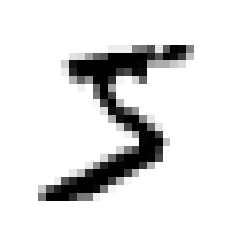

In [5]:
# Tomo una observación de ejemplo
test_digit = X.values[0]
test_label = y[0]

test_digit_image = test_digit.reshape(28, 28)

plt.imshow(test_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
test_label

'5'

Plotteo el 5, y veo que el label es un 5

In [7]:
# Como veo que el label es una string. Convierto toda la serie y a int
y = y.astype(np.uint8)
y.dtype

dtype('uint8')

Check

In [8]:
# Separo en train y test sets 
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# Esto es válido porque el dataset ya viene shuffled. Si no, tendría que separarlo y shufflearlo. No podría hacer el split directamente así.

## Binary classifier
### 5 vs not-5

In [9]:
# Tomo, de los datasets de training y testing, solo los registros cuyo target sea 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
y_test_5

60000    False
60001    False
60002    False
60003    False
60004    False
         ...  
69995    False
69996    False
69997    False
69998     True
69999    False
Name: class, Length: 10000, dtype: bool

#### Esto me va a decir True si es 5 y false si no es 5

In [11]:
# "SGDClassifier es un buen lugar para empezar. Funciona bien con large datasets. It deals with training instances independently"
from sklearn.linear_model import SGDClassifier

In [12]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([test_digit])

array([ True])

In [13]:
test_label

'5'

Bien! Predice 5 y el true label es efectivamente 5

### Classifier performance meassures
Esto es lo más importante. Saber evaluar un classifier es CLAVE

In [14]:
# Primero, voy al cross_val score, como hice con la regresión
from sklearn.model_selection import cross_val_score

In [15]:
# Evalúo, mediante cross validation, la performance del clasificador
scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
for score in scores:
    print(score * 100, "%")

95.035 %
96.035 %
96.04 %


### Trampa de accuracy! 95% Parece MUY bueno. Pero en los clasificadores, la accuracy sola no nos dice mucho. Especialmente cuando los datasets no son parejos en cuanto a distribución de clases. En este caso, la clase 5 representa un 10% del dataset, y la clase not-5 representa un 90% del dataset

In [16]:
# Ejemplo para mostrar la trampa de accuracy:
# Armo un predictor que SIEMPRE devuelva not-5. (independientemente del input)
from sklearn.base import BaseEstimator

class Never_5(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
nvr_5 = Never_5()

nvr_5.fit(X_train, y_train_5)

not_5_scores = cross_val_score(nvr_5, X_train, y_train_5, cv = 3, scoring="accuracy")
for score in not_5_scores:
    print(score * 100, "%")

91.125 %
90.85499999999999 %
90.915 %


De paso... así es como se define un custom estimator
### Con este estimator que predice SIEMPRE la majority class, tenemos un accuracy de 91%. Ahora, 95% no parece taaan bueno

### Confusion matrix
Vamos a ver qué errores está cometiendo el algoritmo

In [18]:
from sklearn.model_selection import cross_val_predict

In [19]:
# Cross val predict es como cross_val_score. Pero te devuelve las predicciones en lugar de devolverte los scores
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# AHH. El cv=3 decide en cuántos folds separa. Esto va a devolver una predicción para cada elemento en el training set. MUY UTIL!
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [20]:
len(y_train_pred)

60000

In [21]:
# Ahora si, vamos a la confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred=y_train_pred, y_true=y_train_5)

array([[53892,   687],
       [ 1891,  3530]])

Eje vertical: Actual classes, Eje horizontal: Predicted classes<br>
Rows: actual classes, Columns: predicted classes <br>
El orden de las filas / columnas es Negative, Positive. Es decir, el primer cuadrante es Negative / Negative

#### A partir de la confusion matrix puedo calcular precision y recall, métricas que complementan el accuracy. Me muestran algo más parecido a la imagen completa

In [22]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true=y_train_5, y_pred=y_train_pred)
recall = recall_score(y_true=y_train_5, y_pred=y_train_pred)

print(f"precision: {round(precision, 4) * 100} %")
print(f"recall: {round(recall, 4) * 100} %")

precision: 83.71 %
recall: 65.12 %


Precision = Minimiza FP (falsos positivos)<br>
Recall = Minimiza FN (falsos negativos)

In [23]:
# f1 score es la media harmónica entre precision y recall
from sklearn.metrics import f1_score

f1_score = f1_score(y_true=y_train_5, y_pred=y_train_pred)
f1_score

0.7325171197343846

Como combina precision y recall, el F1 score es bastante utilizado como métrica. El tema es que tiende a favorecer modelos con precision y recall similares. Personalmente no me gusta demasiado esto. Creo que uno siempre está optimizando para un lado o para otro.

### Jugando con thresholds de decisión para inclinar modificar el trade-off entre precisión y recall
sklearn no te deja tocar directamente los thresholds. Pero nos da el valor de la función de decisión. A partir de este valor, se pueden tomar decisiones con un if (sobre todo en caso de un clasificador binario)

In [24]:
test_y_score = sgd_clf.decision_function([test_digit])
test_y_score

array([2164.22030239])

#### Si yo setteara el threshold en 2000, lo predice como True. Si lo setteo en 3000, lo predice como false. (si subo el threshold, aumento precision a expensas del recall. Voy a tener menos falsos positivos, pero más falsos negativos)

#### ¿Cómo decido el threshold? Vamos a la precision - recall curve 

In [25]:
# Primero, tomo todos los valores de la decision function del training set
y_df_scores = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, cv=3, method="decision_function")

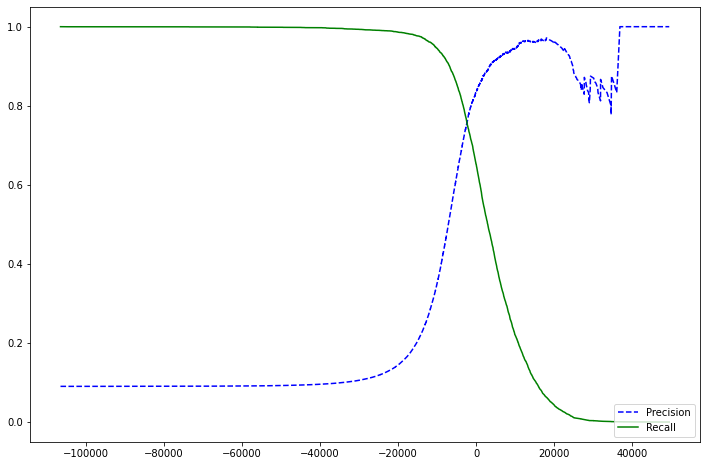

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_df_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plt.figure(figsize=(12, 8))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.legend(loc="lower right")
plt.show()

No handles with labels found to put in legend.


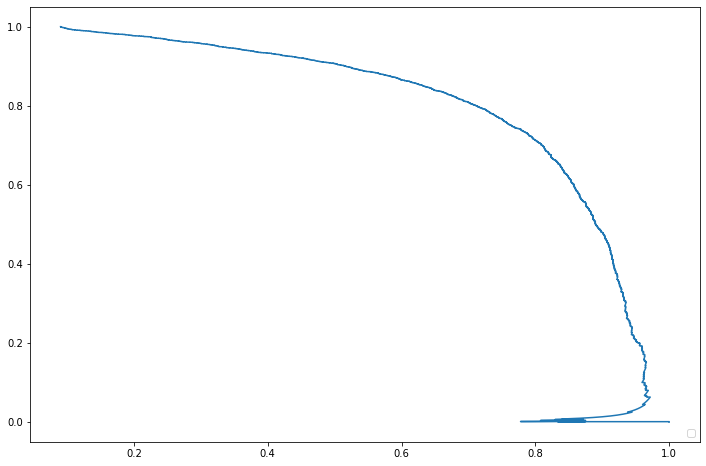

In [27]:
# Plotteo directamente precison vs recall
plt.figure(figsize=(12, 8))
plt.plot(precisions, recalls)
plt.legend(loc="lower right")
plt.show()

#### A partir de esto, intentemos crear un clasificador con 90% precision.

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.019499143958

OK. 3370 es el threshold para que el clasificador tenga 90% de precision.

In [29]:
# Tomo los y_df_scores que calculé antes.
y_train_pred_90 = (y_df_scores >= threshold_90_precision)
precision_score_90 = precision_score(y_true=y_train_5, y_pred=y_train_pred_90)
recall_score_90 = recall_score(y_true=y_train_5, y_pred=y_train_pred_90)

print(f"precision: {precision_score_90 * 100} %")
print(f"recall: {recall_score_90 * 100} %")

precision: 90.00345901072293 %
recall: 47.99852425751706 %


#### Perfecto. Tengo mi clasificador con 90% de precisión. Pero a expensas de la recall

### ROC Curve. Muy útil

No handles with labels found to put in legend.


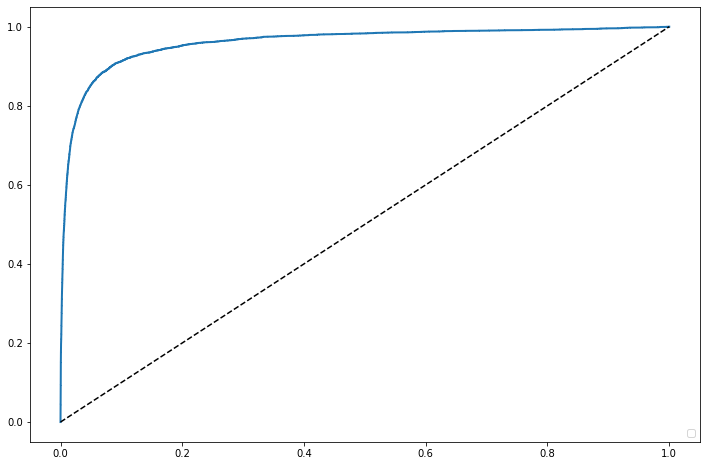

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_df_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal

plt.figure(figsize=(12, 8))
plot_roc_curve(fpr, tpr)
plt.legend(loc="lower right")
plt.show()

In [31]:
# El área debajo de la curva ROC permite comparar 2 clasificadores (1 sería un clasificador prefecto. 0.5 sería un clasificador random)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_true=y_train_5, y_score=y_df_scores)
print(roc_auc)

0.9604938554008616


#### Pruebo otro clasificador: RF

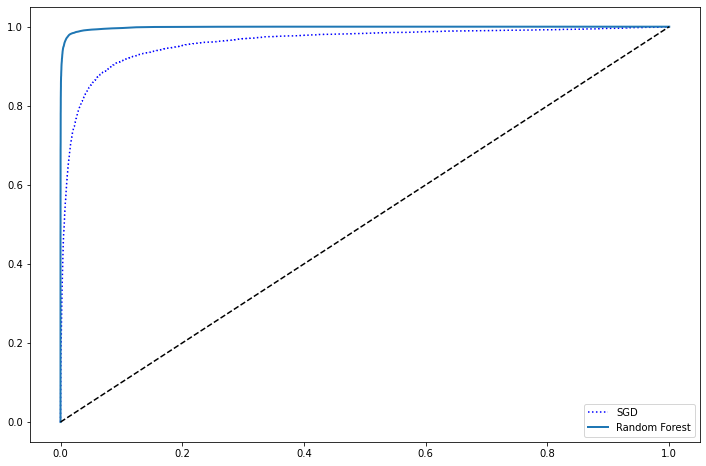

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
# score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [33]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

In [34]:
from sklearn.svm import SVC

svc_clf = SVC()
svc_clf.fit(X_train, y_train)
test_pred = svc_clf.predict([test_digit])
test_pred

array([5], dtype=uint8)

In [35]:
test_pred_scores = svc_clf.decision_function([test_digit])
test_pred_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

Me devuelve 10 scores para esta predicción. Uno para cada dígito. Devuelve la clase con mayor score (en este caso, la clase en el index 5)

In [36]:
np.argmax(test_pred_scores)

5

np.argmax me devuelve el index del elemento con mayor valor en el array.

In [37]:
svc_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [38]:
svc_clf.classes_[np.argmax(test_pred_scores)]

5

Justo sucede que, en este caso, el index coincide con la clase (index 5 = class 5). 

In [39]:
# Si quiero forzar a que el SVC use la estrategia de One-vs-Rest, uso la clase OneVsRest
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
# Después fitteo y todo lo demás

Por el contrario, otros clasficadores soportan la multiclass classification nativamente, por ejemplo, el RF o el SGD

In [40]:
# Ejemplo con SGD
multi_class_sgd = SGDClassifier()
multi_class_sgd.fit(X_train, y_train)
multi_pred = multi_class_sgd.predict([test_digit])
multi_score = multi_class_sgd.decision_function([test_digit])

In [42]:
print(multi_score)
print(np.argmax(multi_score))
print(multi_pred)

[[-13173.57190453 -33440.63536524 -15195.76136427   -280.50323903
  -18297.36350674   2426.24171326 -23655.84896322 -17589.3945247
  -11821.8172761  -16200.02732562]]
5
[5]


Notar que el SGD clasificó como 5 al único valor positivo.  Pero esto no es necesariamente así. Podría tener más de un valor positivo, en ese caso, se elige el máximo valor

## Análisis de errores

In [43]:
multi_y_train_pred = cross_val_predict(multi_class_sgd, X_train, y_train, cv=3)
multi_conf_mx = confusion_matrix(y_true=y_train, y_pred=multi_y_train_pred)
multi_conf_mx

array([[5685,    1,   20,   19,   24,   18,   63,    3,   83,    7],
       [   3, 6393,   37,   67,   12,    6,   36,    9,  171,    8],
       [  65,   57, 4887,  252,   96,   13,  217,   81,  261,   29],
       [  47,   28,  146, 5417,   17,   79,   39,   45,  233,   80],
       [  16,   21,   19,   16, 5246,   13,   86,   19,  139,  267],
       [ 123,   34,   45,  610,  135, 3431,  225,   22,  684,  112],
       [  47,    8,   28,    7,   38,   37, 5691,    2,   57,    3],
       [  28,   18,   51,   74,  117,   11,    5, 5522,   61,  378],
       [  63,  111,   78,  254,   73,   92,  101,   14, 4955,  110],
       [  37,   24,   22,  118,  287,   21,    3,  179,  173, 5085]])

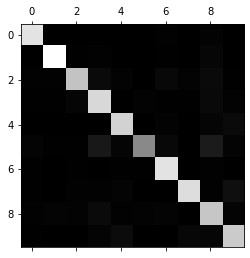

In [44]:
# Representación visual de la confusion matrix
plt.matshow(multi_conf_mx, cmap=plt.cm.gray)
plt.show()

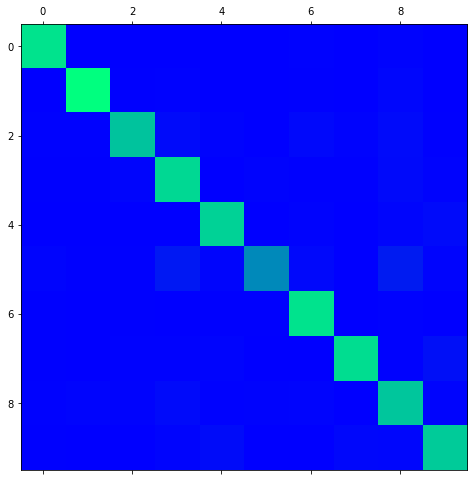

In [52]:
plt.figure(figsize=(8, 8))
plt.matshow(multi_conf_mx, cmap=plt.cm.winter, fignum=1)  # con fignum, le digo que quiero la figure que inicialicé en la línea anterior es la figure sobre la que quiero dibujar.
plt.show()

#### Se ve que los 5s están un poco más oscuros. Ahora, como estoy tratando números absolutos, esto podría ser porque hay menos 5s en el dataset.

In [53]:
row_sums = multi_conf_mx.sum(axis=1, keepdims=True)  # Esto suma por fila. Recordar que las filas son las actual classes. las columnas son las predicted classes

In [54]:
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

Ok... a priori, hay menos 5s

In [56]:
norm_conf_mx = multi_conf_mx / row_sums  # Acá estoy dividiendo la matriz por un vector (el vector de sumas!). PERO NO ES UNA DIVISIÓN (MULTIPLICACIÓN) MATRICIAL!

In [58]:
norm_conf_mx.shape

(10, 10)

Esto no es una multiplicación matricial. Dividió cada elemento en cada fila, por el número correspondiente en el vector suma

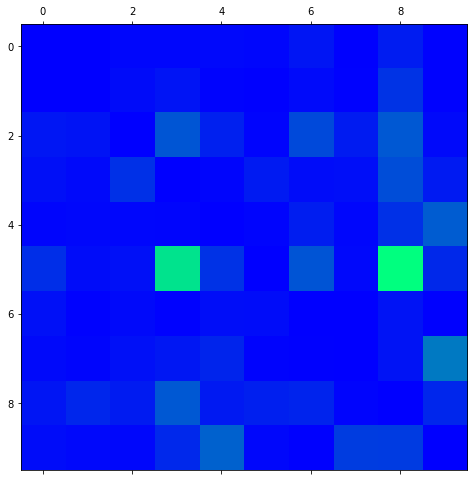

In [60]:
# Lleno la diagonal con 0s, para visualizar únicamente los errores.
np.fill_diagonal(norm_conf_mx, 0)

plt.figure(figsize=(8, 8))
plt.matshow(norm_conf_mx, cmap=plt.cm.winter, fignum=1)
plt.show()

#### Vemos que los mayores errores están en la clase 5. Se confunde los 5s con los 8s y los 3s. (predice 8 ó 3, cuando la clase es 5)

## Multilabel Classification
Hay objetos que pertenecen a más de una clase. En el ejemplo de los números, si hubiera alguna imagen con el número 53, el clasificador multilabel debería devolver "5 y 3". ("ambas clases presentes en la imagen")

In [61]:
# Armo un KNN porque soporta la multilabel classification (no todos la soportan)
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]  # recordar que c_ es una concatenación de arrays
# mi target va a tener shape n x m (n = observations, m = labels)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)


KNeighborsClassifier()

In [62]:
multi_label_pred = knn_clf.predict([test_digit])
multi_label_pred

array([[False,  True]])

Acá me está prediciendo: False para el primer label (o sea que es menor a 7), True para el segundo label (o sea que es impar)<br>
Lo importante es entender el razonamiento: NO ESTÁ PREDICIENDO "5", y clasificando a partir de eso. Está prediciendo cada clase independientemente

Se puede evaluar por label, todo junto, o _weighted_ 

## Multioutput Classification

Ver página 110 del libro!